In [ ]:
# !pip install networkx 
!conda install -c dglteam dgl-cuda10.1 -y
 
# used for distance calculation between cities
!pip install geopy  

# used for visualizing the graphs
!pip install graphviz
!pip install cgraph
!conda install python-graphviz -y
!pip install pygraphviz


In [146]:
# get data from here - https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCity.csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx
from geopy.distance import vincenty
import geopy
import requests
import urllib
import os.path as osp
import torch
import torch.nn.functional as F
import itertools
from dgl.nn.pytorch import GraphConv, SAGEConv

from random import shuffle, randint
import networkx as nx
import matplotlib.pyplot as plt


import dgl
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph


# read data, take only data for USA at the most recent date (day)
df = pd.read_csv('../GlobalLandTemperaturesByCity.csv')
df = df[df['Country']=="United States"]
df = df[df['dt']=="2013-05-01"]
df = df.fillna(0)

df['coords'] = df["Latitude"] + df["Longitude"]
df = df.drop_duplicates(subset="coords")  # remove duplicates

# df = df.head(10)  # used for testing...
df.shape


(97, 8)

In [147]:
# Add elevation for each lat-long - takes ~1sec per coordinate
# USGS Elevation Point Query Service - needs a different format of points, so casted by geopy
url = r'https://nationalmap.gov/epqs/pqs.php?'


def elevation_function(df):
    """Query service using lat, lon. add the elevation values as a new column."""
    elevations = []
    for lat, lon in zip(df["Latitude"], df["Longitude"]):

        pos = geopy.Point.from_string(lat + " " + lon)
        # query params
        params = {
            'output': 'json',
            'x': pos.longitude, 
            'y': pos.latitude, 
            'units': 'Meters'
        }

        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])

    df['elev_meters'] = elevations

elevation_function(df)
df = df[df['elev_meters'] != '-1000000']  # remove nodes with faulty values
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,coords,elev_meters
49875,2013-05-01,22.545,0.125,Abilene,United States,32.95N,100.53W,32.95N100.53W,631.85
140300,2013-05-01,16.789,0.263,Akron,United States,40.99N,80.95W,40.99N80.95W,331.81
170395,2013-05-01,16.290,0.208,Albuquerque,United States,34.56N,107.03W,34.56N107.03W,1595.53
190762,2013-05-01,17.134,0.188,Alexandria,United States,39.38N,76.99W,39.38N76.99W,187.18
205485,2013-05-01,15.544,0.281,Allentown,United States,40.99N,74.56W,40.99N74.56W,327.85


In [148]:
df.to_pickle("data.pkl")


In [588]:
##### RUN CODE FROM HERE!!!
df = pd.read_pickle("data.pkl")



In [589]:
# create the graph - both nx and dgl (converting from nx to dgl failed )
graph= networkx.Graph()
g = dgl.DGLGraph()
num_neighbors = 10

# todo - add vertices - one for each city
for idx, row in enumerate(df.iterrows()):
    avg_temp = float(row[1]["AverageTemperature"])
    # if not idx % 2:
    #     avg_temp = 0  # this is what we attempt to learn!

    elevation = float(row[1]["elev_meters"])

    temp = np.asarray([avg_temp], dtype=np.float32)
    height = np.asarray([elevation], dtype=np.float32)

    graph.add_node(idx, city_name=row[1]["City"], temp=temp, height=height)
    # g.add_nodes(idx, {'city_name': row[1]["City"], 'temp':temp, 'height':height})
    g.add_nodes(1, {'temp': torch.from_numpy(temp), 'height':torch.from_numpy(height)})



for idx1, row1 in enumerate(df.iterrows()):

    v_e_dict = {}
    dists_sorted = []
    for idx2, row2 in enumerate(df.iterrows()):
        pos1 = geopy.Point.from_string(row1[1]["Latitude"] + " " + row1[1]["Longitude"])
        pos2 = geopy.Point.from_string(row2[1]["Latitude"] + " " + row2[1]["Longitude"])
        distance = float(vincenty(pos1, pos2).meters)  # geopy distance
        distance = np.asarray([distance])
        v_e_dict[idx2] = distance  # for this city1, for each city2, save dist in dict
        dists_sorted.append(distance)

    # go over distances, add only 7 closest neighbors
    # AK - 7 was deducted by trail and error, to achieve connected graph!
    dists_sorted.sort()
    dists_sorted = dists_sorted[0:num_neighbors+1]

    for ii, dist in enumerate(v_e_dict.items()):
        city, distance_ = dist
        if distance_ > 0 and distance_ in dists_sorted:
            ### graph.add_edge(row1[1]["City"], row2[1]["City"], distance=distance)
            graph.add_edge(idx1, city, distance=distance_)
            g.add_edge(idx1, city, {'distance':torch.from_numpy(distance_)})





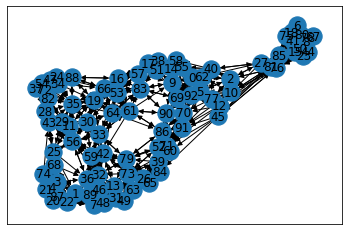

In [590]:
# networkx.draw(graph, with_labels=True, font_weight='bold')


nx.draw_networkx(g.to_networkx())
plt.show()

# from networkx.drawing.nx_agraph import graphviz_layout
# pos = graphviz_layout(graph)
# plt.axis('off')
# nx.draw_networkx_nodes(graph,pos,node_color='g',alpha = 0.8)  # draws nodes
# nx.draw_networkx_edges(graph,pos,edge_color='b',alpha = 0.6)  # draws edges
# nx.draw_networkx_edge_labels(graph,pos,edge_labels = nx.get_edge_attributes(graph,'weight')) # edge lables
# nx.draw_networkx_labels(graph,pos) # node lables

In [591]:
from networkx.algorithms.dominating import dominating_set
g_nx = g.to_networkx()

# # to create our dataset, mimic missing measurements by finding some independent set of graph
# we will attempt to learn it!
remove = dominating_set(g_nx)

keep = np.asarray(list(set(np.arange(len(g_nx))) - remove), dtype=np.int64)
remove = np.asarray(list(remove), dtype=np.int64)
len(keep) + len(remove)
len(remove)

14

In [592]:
class WeighedGraphConv(nn.Module):

    def __init__(self,
                 in_feats,
                 out_feats,
                 num_neighbors, 
                 weight=True,
                 bias=True):
        super(WeighedGraphConv, self).__init__()

        self._in_feats = in_feats
        self._out_feats = out_feats
        self.num_neighbors = num_neighbors

        self.weight = nn.Parameter(torch.Tensor(in_feats, out_feats))
        torch.nn.init.xavier_uniform_(self.weight)

        self.bias = nn.Parameter(torch.Tensor(out_feats))          


    def forward(self, graph, feat, weight=None):
        graph = graph.local_var()
        # normalize input features
        degs = graph.out_degrees().to(feat.device).float().clamp(min=1)
        norm = torch.pow(degs, -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)
        feat = feat * norm

        weight = self.weight

        # mult W first to reduce the feature size for aggregation.
        if weight is not None:
            feat = torch.matmul(feat, weight)
        graph.srcdata['h'] = feat

        efeat = graph.edges[:].data['distance'].unsqueeze(-1)
        efeat = F.softmax(efeat.view(self.num_neighbors, -1), dim=0)
        efeat = 1 - efeat
        efeat = efeat.flatten()

        # (n, d_in, d_out)
        graph.edata['ee'] = efeat
        graph.update_all(fn.u_mul_e('h', 'ee', 'm'), fn.sum('m', 'h'))

        # graph.update_all(fn.copy_src(src='h', out='m'), fn.mean(msg='m', out='h'))
        rst = graph.dstdata['h']

        if self.bias is not None:
            rst = rst + self.bias


        return rst



In [593]:
# First trail - try to learn altitude by proximity and average temp
from dgl.nn.pytorch import GraphConv, SAGEConv

class Net(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, num_neighbors):
        super(Net, self).__init__()
        self.conv1 = WeighedGraphConv(5, 5, num_neighbors)
        self.conv2 = WeighedGraphConv(5, 5, num_neighbors)
        self.conv3 = WeighedGraphConv(5, 2, num_neighbors)


    def forward(self, g, feats_):

        h = self.conv1(g, feats_)
        h = torch.tanh(h)
        # h = torch.nn.functional.leaky_relu(h, 0.1)
        h = self.conv2(g, h)
        h = torch.tanh(h)
        # h = torch.nn.functional.leaky_relu(h, 0.1)
        h = self.conv3(g, h)
        return h

net = Net(5, 5, 2, num_neighbors)  # num_of_classes = temp, altitude
print(net)

embed = nn.Embedding(len(g), 5)  # |g| nodes with embedding dim equal to 5



Net(
  (conv1): WeighedGraphConv()
  (conv2): WeighedGraphConv()
  (conv3): WeighedGraphConv()
)


In [594]:

# data for training
labeled_nodes = torch.from_numpy(remove) # only a small part of the nodes are used for supervision
labeled_temp = g.nodes[labeled_nodes].data['temp']
labeled_height = g.nodes[labeled_nodes].data['height']
labels = torch.stack([labeled_temp, labeled_height], dim=1) # their labels are their height + temp

# data for validation
unlabeled_nodes = torch.from_numpy(keep)
unlabeled_temp = g.nodes[unlabeled_nodes].data['temp']
unlabeled_height = g.nodes[unlabeled_nodes].data['height']
unlabels = torch.stack([unlabeled_temp, unlabeled_height], dim=1) # their labels are their height + temp

features = embed.weight

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.5)
num_epochs = 300

losses = []
accuracies = []

for epoch in range(num_epochs):

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            net.train()  # Set model to training mode
        else:
            net.eval()   # Set model to evaluate mode

        logits = net(g, features)

        if phase == 'train':
            # we only compute loss for labeled nodes
            loss = F.mse_loss(logits[labeled_nodes], labels)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))
            losses.append(loss.item())
        else:
            # training accuracy - 
            mean_err = torch.mean(torch.abs(logits[unlabeled_nodes][:, 0] - unlabels[:, 0] ))
            print("mean temp error is {}".format(mean_err.data))
            accuracies.append(mean_err.data)



och 2 | Loss: 239524.3906
mean temp error is 7.445746898651123
Epoch 3 | Loss: 237460.4688
mean temp error is 9.825048446655273
Epoch 4 | Loss: 235360.5312
mean temp error is 12.473230361938477
Epoch 5 | Loss: 233248.7656
mean temp error is 13.769979476928711
Epoch 6 | Loss: 231132.8906
mean temp error is 13.558252334594727
Epoch 7 | Loss: 229018.0469
mean temp error is 12.269911766052246
Epoch 8 | Loss: 226911.5469
mean temp error is 10.432062149047852
Epoch 9 | Loss: 224819.8906
mean temp error is 8.507824897766113
Epoch 10 | Loss: 222747.8281
mean temp error is 6.909189701080322
Epoch 11 | Loss: 220698.4844
mean temp error is 6.0076518058776855
Epoch 12 | Loss: 218673.2656
mean temp error is 5.7644782066345215
Epoch 13 | Loss: 216672.0469
mean temp error is 5.786586284637451
Epoch 14 | Loss: 214694.0156
mean temp error is 5.750415325164795
Epoch 15 | Loss: 212738.9688
mean temp error is 5.58069372177124
Epoch 16 | Loss: 210807.0469
mean temp error is 5.315032005310059
Epoch 17 | Los

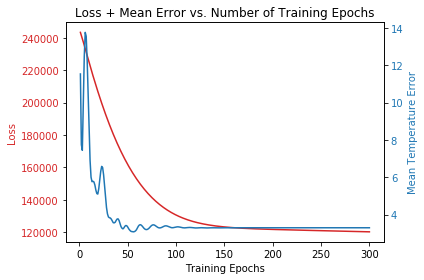

In [595]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1,num_epochs+1),losses,label="Loss", color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.title("Loss + Mean Error vs. Number of Training Epochs")
plt.xlabel("Training Epochs")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("Mean Temperature Error", color=color)  # we already handled the x-label with ax1
ax2.plot(range(1,num_epochs+1),accuracies,label="Mean Temp Error", color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [233]:
# Comparison to Linear Regression / Average of nodes?  TODO

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x, y)
Y_pred = linear_regressor.predict(X)  # make predictions

In [207]:
x1 = np.asarray([df['elev_meters'].values], dtype=np.float32)
x2 = np.asarray([df['AverageTemperature'].values], dtype=np.float32)

x = np.concatenate((x1, x2), axis=0)
x[:, remove]

array([[6.31850e+02, 3.31810e+02, 1.59553e+03, 3.27850e+02, 2.03050e+02,
        7.72100e+01, 9.40000e+00, 4.28370e+02, 2.07470e+02, 1.64899e+03,
        8.31300e+01, 4.00000e-01, 5.43600e+02, 0.00000e+00, 3.23030e+02],
       [2.25450e+01, 1.67890e+01, 1.62900e+01, 1.55440e+01, 1.94410e+01,
        3.76400e+00, 2.48010e+01, 1.79750e+01, 1.79560e+01, 1.28010e+01,
        1.97990e+01, 2.30980e+01, 1.34410e+01, 2.40220e+01, 1.57960e+01]],
      dtype=float32)